In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

Create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/sastrong/repos/segment-anything/notebooks


## Install Segment Anything Model libraries and other dependencies

In [3]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/home/sastrong/repos/segment-anything/notebooks
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-du096xzw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-du096xzw
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [4]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

In [5]:
# !pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.2 MB/s eta 0:00:00


### Use SAM weights
Allow some time to download the weights

In [6]:
# from huggingface_hub import hf_hub_download

# chkpt_path = hf_hub_download("ybelkada/segment-anything", "checkpoints/sam_vit_b_01ec64.pth")

In [ ]:
# %cd {HOME}
# !mkdir {HOME}/weights
# %cd {HOME}/weights

# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
mkdir: cannot create directory ‘/content/weights’: File exists
/content/weights


## Load Model

In [5]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_b"

In [6]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

chkpt_path = '/home/sastrong/repos/segment-anything/weights/sam_vit_b_01ec64.pth'
sam = sam_model_registry[MODEL_TYPE](checkpoint=chkpt_path).to(device=DEVICE)
predictor = SamPredictor(sam)

Unzip dataset. Allow up to a few minutes.

# Preprocess Data

Create custom dataset class. Retrieve images by name dir(0000-9766) rather than index

In [ ]:
from torch.utils.data import Dataset
encoder_size = sam.image_encoder.img_size

class RocksDataset(Dataset):
    def __init__(self, render_dir, ground_dir, transform=None, target_transform=None):
        self.render_dir = render_dir
        self.ground_dir = ground_dir
        self.transform = transform
        self.target_transform = target_transform
        self.imgs = sorted(os.listdir(render_dir))

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.render_dir, img_name)
        mask_path = os.path.join(self.ground_dir, img_name.replace('render', 'ground'))

        image = Image.open(img_path).convert('L')  # Ensure grayscale
        mask = Image.open(mask_path).convert('RGB')  # Ensure RGB

        resize_transform = transforms.Resize((encoder_size, encoder_size))

        image = resize_transform(image)
        mask = resize_transform(mask)

        # Generate bounding boxes from the mask
        mask_np = np.array(mask)
        boxes = generate_bboxes_from_mask(mask_np)

        # Convert the boxes to a tensor
        boxes_torch = torch.tensor(boxes, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, boxes_torch  # Now returning three items instead of two

    def get_gt_binary_mask(self, idx):
            img_name = self.imgs[idx]
            mask_path = os.path.join(self.ground_dir, img_name.replace('render', 'ground'))

            mask = Image.open(mask_path).convert('RGB')  # Ensure RGB
            mask_np = np.array(mask)
            return generate_binary_mask_from_mask(mask_np)

    def __len__(self):
        return len(self.imgs)

Transform grayscale to RGB. This is just repeating the grayscale image across three channels. This does not add any additional information to the image.

In [ ]:
class GrayToRGBTransform:
    def __call__(self, image):
        return image.convert('RGB')

Helper function to map colors to class indices in ground imgs

# Define transforms

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F
from segment_anything.utils.transforms import ResizeLongestSide

# Transforms for the rendered images
render_transforms = transforms.Compose([
    GrayToRGBTransform(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # normalize to what sam was trained on
])

# Transforms for the ground truth images
ground_transforms = transforms.Compose([
    transforms.ToTensor()
])

# Set the paths to the 'render' and 'ground' directories
render_dir = '/content/lunar_imgs/render'
ground_dir = '/content/lunar_imgs/ground'

# Create the dataset and dataloader
dataset = RocksDataset(render_dir, ground_dir, transform=render_transforms, target_transform=ground_transforms)

def collate_fn(batch):
    # Filter out images with no boxes
    batch = [item for item in batch if len(item[1]) > 0]

    if len(batch) == 0:
        return None

    images, boxes_list = zip(*batch)

    # Stack images normally
    images = torch.stack(images)

    # Determine maximum number of boxes
    max_boxes = max(len(boxes) for boxes in boxes_list)

    # Create a tensor to hold the padded boxes
    padded_boxes = torch.zeros(len(batch), max_boxes, 4)

    # Copy each set of boxes into the padded tensor
    for i, boxes in enumerate(boxes_list):
        if len(boxes) > 0:
            padded_boxes[i, :len(boxes)] = boxes

    return images, padded_boxes

    # [5, 50, 4]
    # img 1 has 20 bbox, 2 has 60bbox
    # model looks at one bounding box each time, 80 loops

dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)


# Define the optimizer, set up loss function, fine-tune

In [ ]:
optimizer = torch.optim.Adam(sam.mask_decoder.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()()
sam.train()

# Fine tune the model

In [ ]:
import numpy as np
# Epochs
num_epochs = 3
losses = []

# Training loop
for epoch in range(num_epochs):  # num_epochs to be defined
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    for batch in dataloader:
        if batch is None:
            print('1.5')
            continue
        input_image, box_torch = batch
        input_image, box_torch = input_image.to(DEVICE), box_torch.to(DEVICE)
        num_boxes = box_torch.size(1)
        print(f"Num boxes {num_boxes}")
        # Image encoding
        with torch.no_grad():
            image_embedding = sam.image_encoder(input_image)
            image_embedding = torch.repeat_interleave(image_embedding, num_boxes, dim=0)
        # Prompt encoding
        box_torch_reshaped = box_torch.view(-1, box_torch.size(-1))
        with torch.no_grad():
            print(f"Input Box Torch shape for prompt_encoder: {box_torch_reshaped.shape}")
            sparse_embeddings, dense_embeddings = sam.prompt_encoder(points=None, boxes=box_torch_reshaped, masks=None)
            print(f"Sparse Embeddings shape: {sparse_embeddings.shape}")
            print(f"Dense Embeddings shape: {dense_embeddings.shape}")

        # Suppose 'num_boxes' is the number of boxes for each element in the batch (87 in your case)
        # You would reshape the embeddings back to [2, 87, embedding_size]
        num_boxes = box_torch_reshaped.size(0)
        sparse_embeddings = sparse_embeddings.view(-1, num_boxes, sparse_embeddings.size(-1))
        dense_embeddings = dense_embeddings.view(-1, num_boxes, *dense_embeddings.shape[2:])

        # Mask decoding
        print('4')
        low_res_masks, iou_predictions = sam.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=sam.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

        # Postprocessing
        print('5')
        input_size = (1024, 1024)
        original_image_size = (720, 480)
        upscaled_masks = sam.postprocess_masks(low_res_masks, input_size, original_image_size).to(DEVICE)

        # Generate ground truth binary
        print('6')
        input_image_np = input_image[0].cpu().numpy()  # Convert tensor to NumPy array
        gt_binary_mask = generate_binary_mask_from_mask(input_image_np)

        # Generate binary mask
        print('7')
        binary_mask = F.normalize(F.threshold(upscaled_masks, 0.0, 0)).to(DEVICE)

        # Calculate loss and backpropagate
        print('8')
        loss = loss_fn(binary_mask, gt_binary_mask)
        print(loss)
        losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Save the fine-tuned model
torch.save(sam.state_dict(), 'sam_terrestrial_rocks.pth')

Epoch 0/2
----------
Num boxes 128


OutOfMemoryError: ignored

In [10]:
import os

chkpt_tuned = "/content/sam_terrestrial_rocks.pth"
print(chkpt_tuned, "; exist:", os.path.isfile(chkpt_tuned))
sam_tuned = sam_model_registry[MODEL_TYPE](checkpoint=chkpt_path).to(device=DEVICE)

/content/sam_terrestrial_rocks.pth ; exist: False


## Upload Image(s)

In [11]:
from google.colab import files
import cv2
uploaded = files.upload()
imgs = []
for fn in uploaded.keys():
  with open(fn, 'wb') as f:
    f.write(uploaded[fn])

  imgs.append(cv2.imread(fn))

Saving 0039MR0001790010101234E01_DXXX.jpg to 0039MR0001790010101234E01_DXXX.jpg


In [8]:
import cv2

# Path to the image
image_path = "/home/sastrong/repos/segment-anything/notebooks/images/rocks.jpg"

# Read the image
image = cv2.imread(image_path)

# Verify if the image is loaded
if image is None:
    print('Could not open or find the image')
else:
    print('Image is loaded')

imgs = [image]

Image is loaded


In [23]:
import cv2
import os
import glob

# Path to the directory with images
imgs_path = '/home/sastrong/repos/M2020_clastsurveys'

# Get a list of all jpeg files in the directory
imgs_files = glob.glob(os.path.join(imgs_path, '*.png'))

# Initialize an empty list to store the images
imgs = []

len = 0

# Loop over all files
for img_file in imgs_files:
    print(img_file)
    len += 1
    # Read the image
    img = cv2.imread(img_file)
    if len == 5:
        break

    # Verify if the image is loaded
    if img is None:
        print(f'Could not open or find the image: {img_file}')
    else:
        # Get the dimensions of the image
        height, width, channels = img.shape

        imgs.append(img)


/home/sastrong/repos/M2020_clastsurveys/ZLF_0351_0698094473_738FDR_N0093478ZCAM07114_0340LMJ01.png
/home/sastrong/repos/M2020_clastsurveys/ZLF_0351_0698094607_764FDR_N0093478ZCAM07114_1100LMJ01.png
/home/sastrong/repos/M2020_clastsurveys/ZLF_0352_0698200846_318FDR_N0095676ZCAM07114_1100LMJ01.png
/home/sastrong/repos/M2020_clastsurveys/ZLF_0351_0698113761_832FDR_N0095156ZCAM07114_0340LMJ01.png
/home/sastrong/repos/M2020_clastsurveys/ZLF_0351_0698113856_832FDR_N0095156ZCAM07114_1100LMJ01.png


## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [24]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.8,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=50,  # Requires open-cv to run post-processing
)

### Generate masks with SAM

In [25]:
import cv2

results = []
for image in imgs:
  sam_result = mask_generator.generate(image)
  results.append(sam_result)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

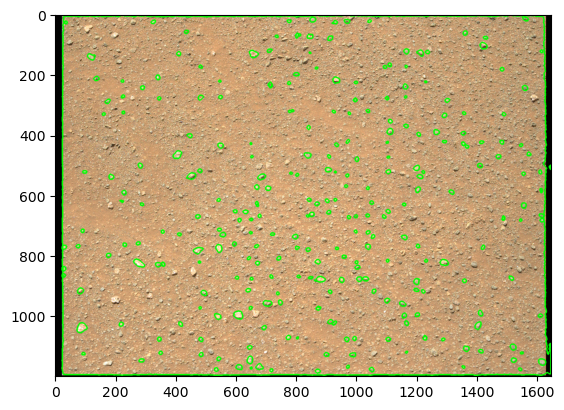

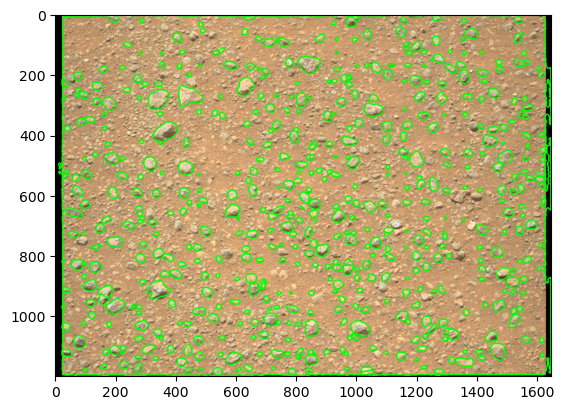

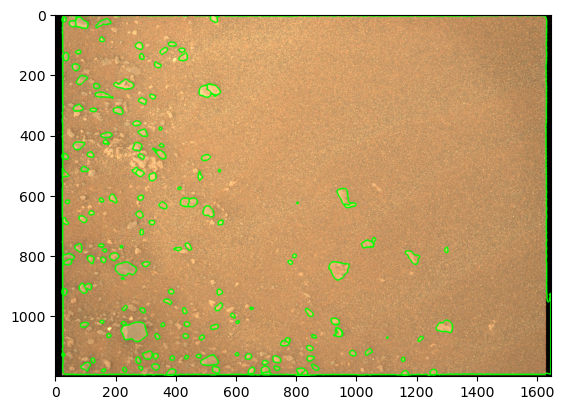

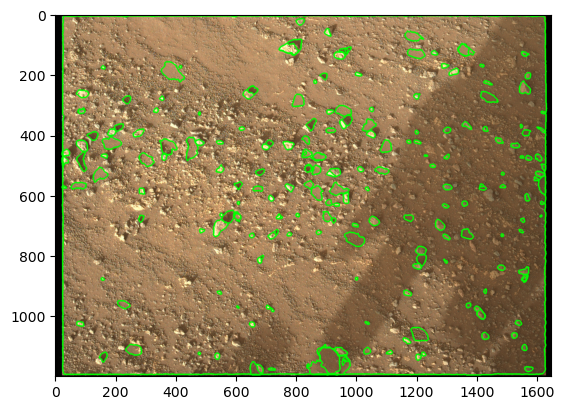

In [37]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

i = 0
for result in results:
    img = imgs[i].copy()
    i+=1
    for annotation in result:
        mask = (annotation['segmentation'].astype(bool) * 255).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img, contours, -1, (0,255,0), thickness=3)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB for matplotlib
    plt.show()


### Print desired segmentation characteristics

In [ ]:
# print area for each rock in img
i = 1
for img in results:
  print(f"Info for image {i}. Detected {len(img)} rocks total")
  j = 1
  for mask in img:
    print(f" rock {j}: area = {mask['area']}px")
    j+=1
  i+=1

Info for image 1. Detected 352 rocks total
 rock 1: area = 30249px
 rock 2: area = 11030px
 rock 3: area = 12085px
 rock 4: area = 3416px
 rock 5: area = 3405px
 rock 6: area = 2880px
 rock 7: area = 1166px
 rock 8: area = 2453px
 rock 9: area = 1682px
 rock 10: area = 2208px
 rock 11: area = 2777px
 rock 12: area = 4776px
 rock 13: area = 1429px
 rock 14: area = 1447px
 rock 15: area = 1888px
 rock 16: area = 1850px
 rock 17: area = 2308px
 rock 18: area = 956px
 rock 19: area = 1220px
 rock 20: area = 1250px
 rock 21: area = 3011px
 rock 22: area = 2613px
 rock 23: area = 944px
 rock 24: area = 4222px
 rock 25: area = 848px
 rock 26: area = 3746px
 rock 27: area = 533px
 rock 28: area = 708px
 rock 29: area = 1128px
 rock 30: area = 2561px
 rock 31: area = 721px
 rock 32: area = 880px
 rock 33: area = 1086px
 rock 34: area = 1637px
 rock 35: area = 870px
 rock 36: area = 1340px
 rock 37: area = 1796px
 rock 38: area = 330px
 rock 39: area = 2530px
 rock 40: area = 2222px
 rock 41: ar